In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import os 
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import collections

from shutil import get_terminal_size

In [20]:
## LOOKS AT THE DATA
df1 = pd.read_csv("details.csv"); #print(df1) 
df2 = pd.read_csv("details_fixed.csv"); #print(df2) 


df3 = pd.read_csv("payments.csv"); print(df3) 
df4 = pd.read_csv("profiling.csv"); print(df4) 

               ID  CountDeposit  CountWithdrawal  TotalDeposits  \
0       100001096            86               17           3218   
1       100002057            26                0            300   
2       100009325            76                9            558   
3       100014865            21                0            475   
4       100018655            45                3            915   
...           ...           ...              ...            ...   
207393  899973616            38                2            715   
207394  899987209           192               31           3882   
207395  899994536             1                1            100   
207396  899994603             1                0             10   
207397  899998254             5                0           1400   

        TotalWithdrawal  CountPaymentMethod  DifferentMethodWithdrawals  
0                  2622                   1                      2359.8  
1                     0                   1    

In [11]:
## MERGE BY ID
df23 = df2.merge(df3,on = 'ID')
df234 = df23.merge(df4,on = 'ID'); print(df234.describe())

                 ID      Life_Time            Age      Is_Retail  \
count  2.073980e+05  207398.000000  207398.000000  207398.000000   
mean   5.008909e+08       2.603342      41.490410       0.410023   
std    2.306288e+08       3.122641      13.123745       0.491839   
min    1.000011e+08       0.000000      18.000000       0.000000   
25%    3.009800e+08       0.000000      31.000000       0.000000   
50%    5.018123e+08       1.000000      39.000000       0.000000   
75%    7.004120e+08       4.000000      51.000000       1.000000   
max    8.999983e+08      21.000000     120.000000       1.000000   

        Is_CRM_Email   CountDeposit  CountWithdrawal  TotalDeposits  \
count  207398.000000  207398.000000    207398.000000   2.073980e+05   
mean        0.418042      26.245721         2.734848   1.418705e+03   
std         0.493238      41.822574         7.559037   5.183685e+03   
min         0.000000       1.000000         0.000000   5.000000e+00   
25%         0.000000       4.000

In [21]:
## CHECK FOR MISSING VALUES
def missing(data):
    cols = data.columns 
    for (i,col) in enumerate(cols):
        print("Column %s  - missing values = " %(col), data[col].isnull().sum())
missing(df234)

Column ID  - missing values =  0
Column Life_Time  - missing values =  0
Column Age  - missing values =  0
Column Is_Retail  - missing values =  0
Column Is_CRM_Email  - missing values =  0
Column CountDeposit  - missing values =  0
Column CountWithdrawal  - missing values =  0
Column TotalDeposits  - missing values =  0
Column TotalWithdrawal  - missing values =  0
Column CountPaymentMethod  - missing values =  0
Column DifferentMethodWithdrawals  - missing values =  0
Column Multi_Device  - missing values =  0
Column IP_Counts  - missing values =  0
Column e_11234  - missing values =  0
Column e_23456  - missing values =  0
Column e_34454  - missing values =  0
Column e_43568  - missing values =  0
Column e_64645  - missing values =  0


In [22]:
## ADD SUSPECT PLAYERS
df5 = pd.read_csv("suspect.csv"); print(df5); print(df5.describe())
print(df234.loc[df234['ID'] == 100095464]) # LOOKS LIKE THESE ALREADY IN OTHER DATAFRAME

df2345 = pd.merge(df234, df5, how='outer', on='ID');
df2345['Target_ml'] = df2345['Target_ml'].replace(np.nan, 0)
df2345['Target_ml'] = df2345['Target_ml'].astype(int)
print(df2345); print(df2345.describe())

             ID  Target_ml
0     100095464          1
1     100333793          1
2     101329354          1
3     101607100          1
4     102590942          1
...         ...        ...
1747  898004908          1
1748  898448610          1
1749  899624336          1
1750  899737861          1
1751  899788191          1

[1752 rows x 2 columns]
                 ID  Target_ml
count  1.752000e+03     1752.0
mean   4.995049e+08        1.0
std    2.322098e+08        0.0
min    1.000955e+08        1.0
25%    2.941709e+08        1.0
50%    4.951482e+08        1.0
75%    6.985999e+08        1.0
max    8.997882e+08        1.0
           ID  Life_Time  Age  Is_Retail  Is_CRM_Email  CountDeposit  \
26  100095464          9   55          0             0           222   

    CountWithdrawal  TotalDeposits  TotalWithdrawal  CountPaymentMethod  \
26               38           5640             5200                   4   

    DifferentMethodWithdrawals  Multi_Device  IP_Counts  e_11234  e_23456  \

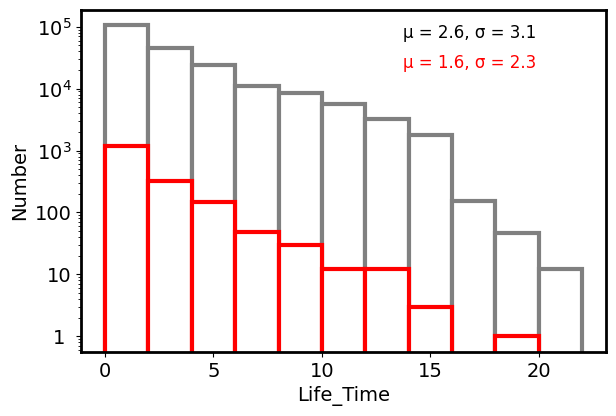

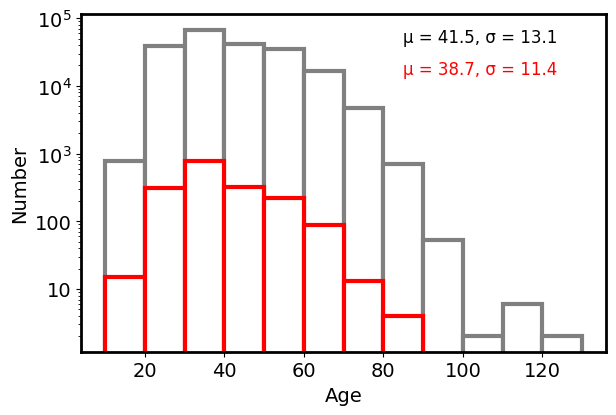

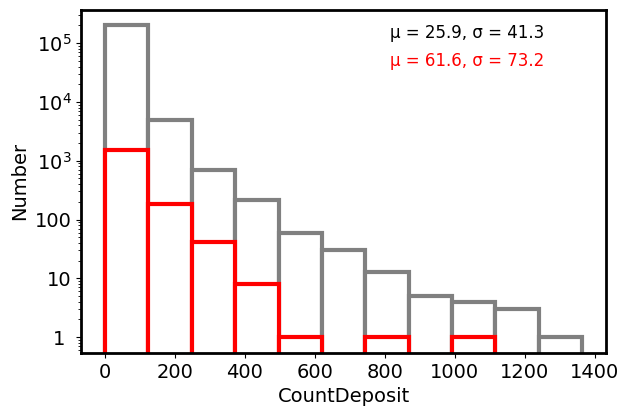

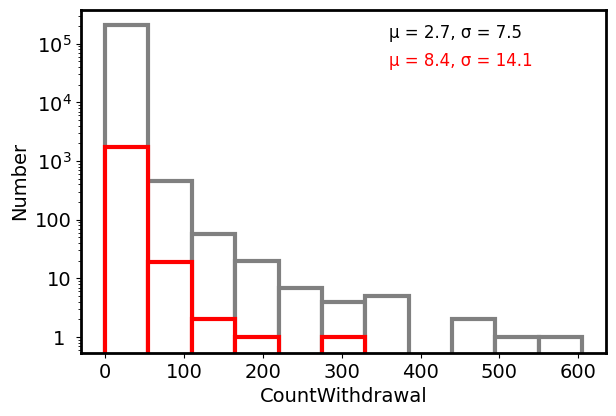

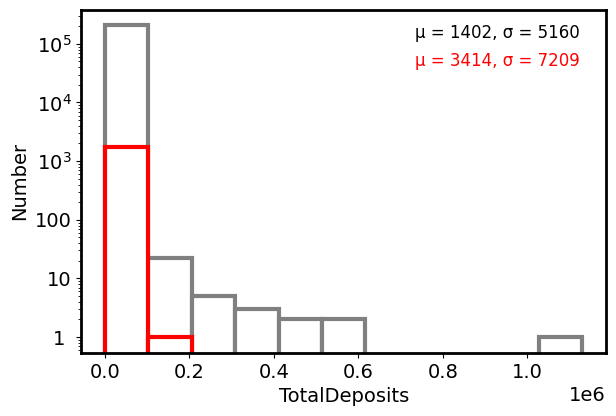

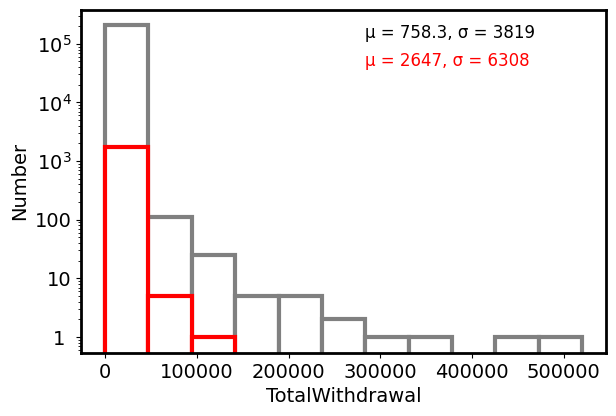

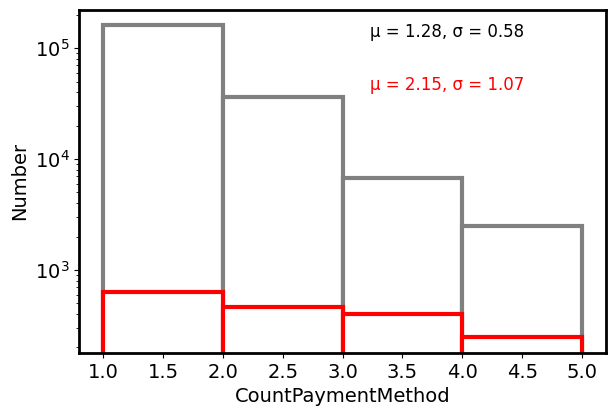

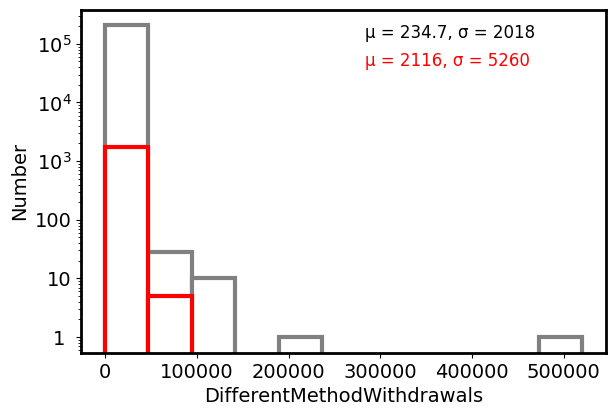

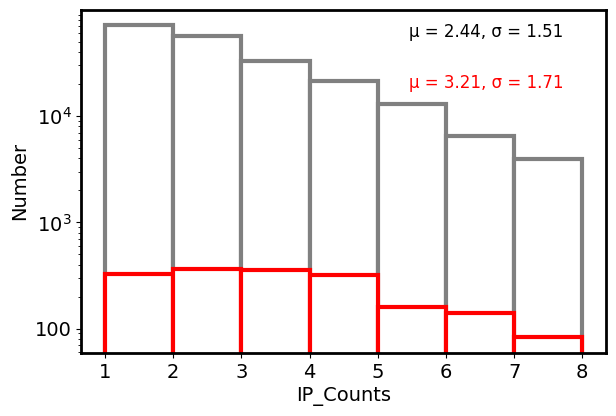

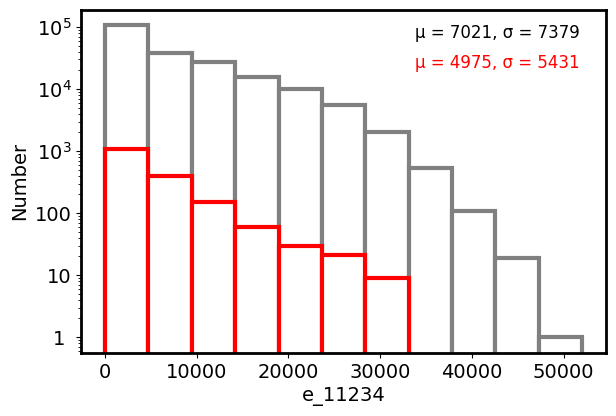

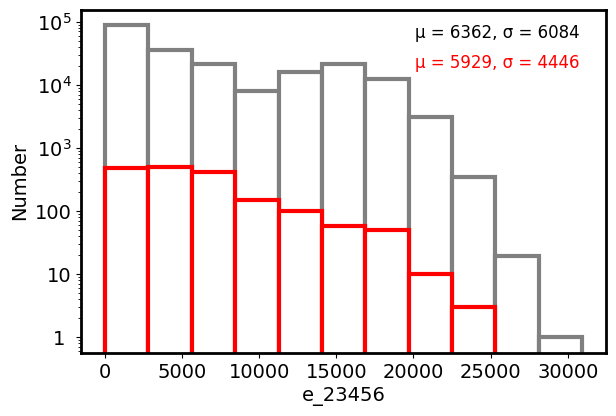

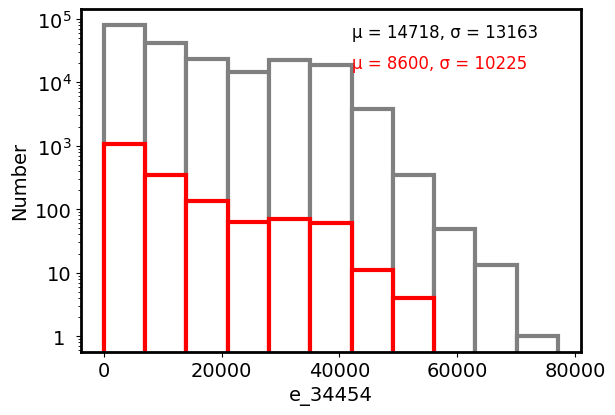

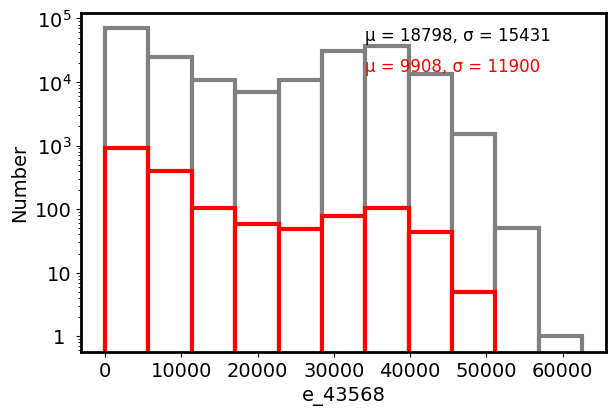

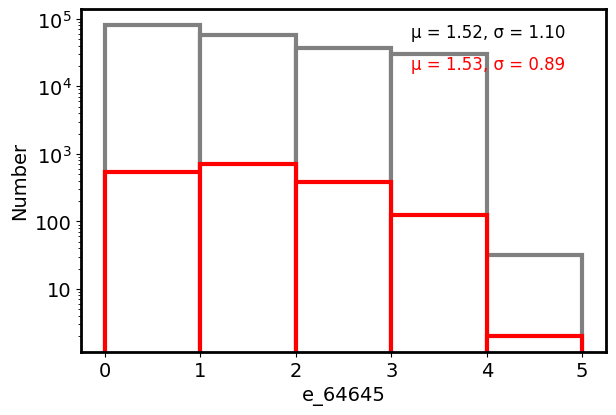

In [24]:
## PLOT HISTOGRAMS OF FEATURES
df = df2345.copy()
paras = ['Life_Time', 'Age', 'CountDeposit', 'CountWithdrawal', 'TotalDeposits', 'TotalWithdrawal', 'CountPaymentMethod', 'DifferentMethodWithdrawals', 'IP_Counts', 'e_11234', 'e_23456', 'e_34454', 'e_43568','e_64645']

for (i, para) in enumerate(paras):
    xmin = min(df[para]); 
    xmax = max(df[para]);
    
    if para == 'CountPaymentMethod':
        desired_bin_size = 1
    elif para == 'IP_Counts':
        desired_bin_size = 1
    elif para == 'e_64645':
        desired_bin_size = 1
    else:
        desired_bin_size =  int((xmax-xmin)/10)
    
    data = df[para]
    min_val = np.min(data); max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    plt.setp(ax.spines.values(),linewidth=2)

    text = '%s' %(para)
    plt.ylabel('Number', size=14); plt.xlabel(text, size=14)
    sus = df.loc[df['Target_ml'] == 1]
    non = df.loc[df['Target_ml'] == 0]; #print(len(sus),len(non))
    
    ax.hist(non[para], bins=bins, color="w", edgecolor='grey', linewidth=3);
    mean = np.mean(non[para]); std = np.std(non[para])

    ymin, ymax = plt.ylim(); #print(ymax)
         
    if xmax < 10:
        text = "\u03BC = %1.2f, \u03C3 = %1.2f" %(mean,std); xoff = 3.9
    elif xmax >10 and mean <= 100:
        text = "\u03BC = %1.1f, \u03C3 = %1.1f" %(mean,std); xoff = 2.9
    elif xmax >100 and mean <= 1000:
        text = "\u03BC = %1.1f, \u03C3 = %1.0f" %(mean,std);xoff = 2.5  
    elif xmax > 1000 and mean <= 10000:
        text = "\u03BC = %1.0f, \u03C3 = %1.0f" %(mean,std); xoff = 3.5
    else:
        text = "\u03BC = %1.0f, \u03C3 = %1.0f" %(mean,std); xoff = 2.5
        
   
    x_pos = xmax-((xmax-xmin)/xoff); y_pos = ymax; y_skip =  ymax-((ymax-ymin)/3);  
    plt.text(x_pos,y_pos, text, fontsize = 12, c = 'k', horizontalalignment='left',verticalalignment='top') 
    
    ax.hist(sus[para], bins=bins, color="w", edgecolor='r', linewidth=3);
    mean = np.mean(sus[para]); std = np.std(sus[para])
    if xmax < 10:
        text = "\u03BC = %1.2f, \u03C3 = %1.2f" %(mean,std); xoff = 3.9
    elif xmax >10 and mean < 100:
        text = "\u03BC = %1.1f, \u03C3 = %1.1f" %(mean,std); xoff = 2.9
    elif xmax >100 and mean < 1000:
        text = "\u03BC = %1.1f, \u03C3 = %1.0f" %(mean,std);xoff = 2.5  
    else:
        text = "\u03BC = %1.0f, \u03C3 = %1.0f" %(mean,std);xoff = 2.2
    
    plt.text(x_pos,y_pos-y_skip, text, fontsize = 12, c = 'r', horizontalalignment='left',verticalalignment='top') 
    
    ax.set_yscale('log');
    def update_ticks(z, pos):
        if z ==1:
            return '1 '
        elif z >1 and z <1000:
            return '%d' %(z)
        elif z < 1 and z > 0.001:
            return z
        else:
            return  '10$^{%1.0f}$' %(np.log10(z)) 

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
      
    plt.tight_layout(pad=0.1)
    plt.show()


In [25]:
############# MACHINE LEARNING ###############

## RANDOMISE
df = df.sample(frac=1)
df['Target_ml'] = df['Target_ml'].astype(int)

target = 'Target_ml'

## BALANCE DATASET
sus = df[df[target] == 1]; n1 = len(sus)
not_sus = df[df[target] == 0]; n0 = len(not_sus)

if n1 > n0:
    class0 = df.loc[df[target] == 0]
    class1 = df.loc[df[target] == 1][:n0]
else:
    class0 = df.loc[df[target] == 0][:n1]
    class1 = df.loc[df[target] == 1]
print("Sample sizes now", len(class0),len(class1))
df = pd.concat([class0, class1])

df = df.reindex(np.random.permutation(df.index))
df.reset_index(drop=True, inplace=True)
del df['ID']
#print(df)

Sample sizes now 1752 1752


In [26]:
## SPLIT INTO TRAINING AND TEST
test_frac = 0.2
max_iter = 1000
n_neighbors = 26
max_depth = 6
cv = 10

X = df.drop([target], axis = 1); y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, random_state = 42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
## ML
classifiers = {
    "LR": LogisticRegression(C=0.004832930238571752, solver='newton-cg'),
    "KNN": KNeighborsClassifier(n_neighbors=n_neighbors),
    "SVC": SVC(C=1, gamma=0.1),
    "DTR": DecisionTreeClassifier(max_depth = max_depth),
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=cv) 
    print("For a %1.1f test fraction (%d train & %d test) %s score = %1.3f" %(test_frac, len(X_train), len(X_test), key, training_score.mean()*100))

    #prediction = classifier.predict(X_train); print('Training\n',confusion_matrix(prediction, y_train))
    #prediction = classifier.predict(X_test); print('Testing\n', confusion_matrix(prediction, y_test))

    #FEATURE IMPORTANCE #########
    # from sklearn.inspection import permutation_importance
    # results = permutation_importance(classifier, X_train, y_train, scoring='accuracy')
    # importance = results.importances_mean
    # features = df.drop(target,axis = 1) 
    # features = features.columns.tolist()
    # df1 = pd.DataFrame(features, columns=['Feature']); 
    # df2 = pd.DataFrame(importance, columns=['Importance'])
    # df1['Importance'] = df2.Importance  # adding to df1
    # print(df1.sort_values(by=['Importance'], ascending=False)) 


For a 0.2 test fraction (2803 train & 701 test) LR score = 76.633
For a 0.2 test fraction (2803 train & 701 test) KNN score = 79.700
For a 0.2 test fraction (2803 train & 701 test) SVC score = 81.413
For a 0.2 test fraction (2803 train & 701 test) DTR score = 80.772
